# Predicting Dengue Fever Cases using weather data via Catboost Algorithm

### Introduction

This project aims to tackle the Dengue Fever Challenge posted on Driven Data.
Five steps are included in this markdown:
1. importing packages and reading data from source
2. conducting basic EDA (Exploration Data Analysis)
3. feature engineering
4. train a model and test result simply using training data
5. train the model again using all training data and do prediction for the 'submit' set

### Step 1: importing packages and reading data from source 

In [19]:
# import packages
import pandas as pd
import numpy as np
import os 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

In [20]:
# reading data
path = os.getcwd() + "/../Data/numero_de_casos/"

data = {}
for file in os.listdir(path):
    data[re.sub(".csv", "", file)] = pd.read_csv(path + file)

training_X = data.pop("dengue_features_train")
training_Y = data.pop("dengue_labels_train")
submit_X = data.pop("dengue_features_test")
submit_Y = data.pop("submission_format")

# joining data for train_test_split in the later stage
training = training_X.merge(training_Y, on=['city', 'year', 'weekofyear'], how='left')
submit = submit_X.merge(submit_Y, on=['city', 'year', 'weekofyear'], how='left')

training.shape

(1456, 10)

### Step 3: feature engineering

Based on the exploratory data analysis, it seems that the following steps could/should be done:
1. generating datetime features
2. filling NAs
3. removing highly correlated features
4. one-hot encoding for categorical features

For step 2, since the NA values for each column are weather related data, it makes sense to fillna in groups of city and month.
And as the NA values only accounts for less than 10% of the total data for each column, a naive method, median would be used.

In [21]:
# generating date_time features
training['week_start_date'] = pd.to_datetime(training['week_start_date'], format='%Y-%m-%d')
training['quarter'] = training.week_start_date.dt.quarter
training['month'] = training.week_start_date.dt.month
training['day'] = training.week_start_date.dt.day

submit['week_start_date'] = pd.to_datetime(submit['week_start_date'], format='%Y-%m-%d')
submit['quarter'] = submit.week_start_date.dt.quarter
submit['month'] = submit.week_start_date.dt.month
submit['day'] = submit.week_start_date.dt.day

#training.columns()

In [22]:
# fillna via naive method, median, grouped by city and month
training = training.groupby(['city', 'month']).apply(lambda x: x.fillna(x.median())).reset_index(level=[0,1])
submit = submit.groupby(['city', 'month']).apply(lambda x: x.fillna(x.median())).reset_index(level=[0,1])

training.head()


,city,month,year,weekofyear,week_start_date,humidity_percent,avg_temp_c,max_temp_c,min_temp_c,precip_mm,total_cases,quarter,day
962,iq,1,2001,1,2001-01-01,94.955714,27.333333,33.3,21.8,38.9,0,1,1
963,iq,1,2001,2,2001-01-08,82.347143,27.000000,33.2,20.7,59.9,0,1,8
964,iq,1,2001,3,2001-01-15,84.175714,27.050000,33.0,20.5,52.0,0,1,15
965,iq,1,2001,4,2001-01-22,94.057143,25.716667,31.2,20.0,166.9,0,1,22
966,iq,1,2001,5,2001-01-29,95.407143,26.433333,33.0,20.0,147.8,0,1,29


In [24]:
# one-hot encoding for categorical data: city
training = pd.concat([pd.get_dummies(training.city).astype(int), training], axis=1)
submit = pd.concat([pd.get_dummies(submit.city).astype(int), submit], axis=1)

### Step 4: Build Model

In [25]:
# drop week_start_date before training
training.drop(['week_start_date'], axis=1, inplace=True)
submit.drop(['week_start_date'], axis=1, inplace=True)

In [27]:
# Build the NN model
model = Sequential()
model.add(Dense(46, input_dim=12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(92, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(46, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(23, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')

### Step 5: train the model again using all training data and do prediction for the 'submit' set

In [31]:
# train test split for train, and cv
X_train, X_cv, y_train, y_cv = train_test_split(training.drop(['total_cases'], axis=1), training.total_cases, test_size=0.3, stratify=training.city, random_state=64)
X_train.drop('city', axis=1, inplace=True)
X_cv.drop('city', axis=1, inplace=True)

In [32]:
# build model
submission_model = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), batch_size=25, epochs=600, shuffle=True, verbose=False)

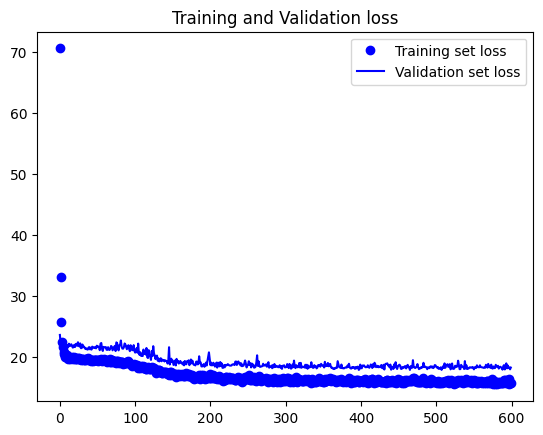

In [33]:
# Inspect loss over epochs
loss = submission_model.history['loss']
val_loss = submission_model.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training set loss')
plt.plot(epochs, val_loss, 'b', label='Validation set loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
model.save("./../modelos/modelo_dengue_reducido.keras")

In [34]:
# do prediction on the 'submit' data and save as csv for final submission
submit_cases_prediction = model.predict(submit.drop(['total_cases', 'city'], axis=1))
submit_Y.total_cases = submit_cases_prediction.astype(int)
print('Mean Absolute Error:', MAE( submit['total_cases'], submit_cases_prediction))

13/13 [==============================] - 0s 1ms/step
Mean Absolute Error: 12.203308694064617
